# EDA of hotel data 酒店预订数据的综合分析<br>
My work can be simple described as 3 part: <br> a.Roughly feel of the data <br> 数据的简单浏览 <br> b. Predict cancel rate using logistic regression<br>使用Logistic回归预测用户退订情况<br>c. Predict cancel rate using random forest<br>使用随机森林预测用户退订情况

# PART 1.<br>Have a feel of hotel data using python pandas<br> 简单的浏览数据

In [96]:
# import libs
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

In [97]:
df = pd.read_csv('../input/hotel-booking-demand/hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# **Q1** <br>**a.Which kind of hotel is more popular?** <br>哪一种酒店更受欢迎？<br> **b.Which kind of hotel have higher cancel rate?**<br> 哪一种酒店有更高的退订率？<br>

In [98]:
df["hotel"].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

In [99]:
df_resort = df[df.hotel == 'Resort Hotel']
cancel_resort = round(len(df_resort[df_resort.is_canceled == 1])/ len(df_resort),3)
df_city = df[df.hotel == 'City Hotel']
cancel_city = round(len(df_city[df_city.is_canceled == 1])/ len(df_city),3)
print("cancel rate for resort is ",cancel_resort)
print("cancel rate for city is ", cancel_city)


cancel rate for resort is  0.278
cancel rate for city is  0.417


# **Q1 answer**<br>
a. Regardless of the cancelation, city hotel is more popular since its reservation is larger.<br>不考虑取消订单的情况，城市酒店比假日酒店更受欢迎，因为它的预订量更大。<br>b. Cancel rate of city hotel is two times higher then resort one. <br>城市酒店的退订率比假日酒店的高将近一倍

# **Q2**<br>**When is peak hotel occupancy?** <br> 入住酒店高峰期

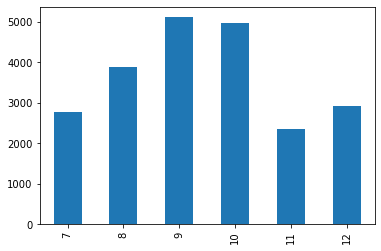

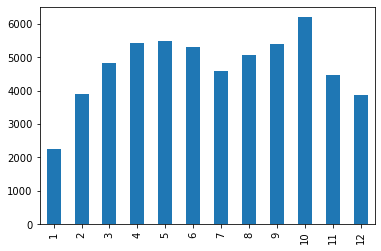

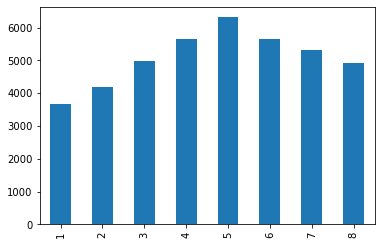

In [100]:
df1 = df.copy()
month = {'January':1, "February":2, "March":3, "April":4,"May":5,"June":6, "July":7, "August":8, "September":9,"October":10, "November":11, "December":12}
df1.arrival_date_month = df1.arrival_date_month.apply(lambda x: month[x])
df1 = df1.sort_values(by = 'arrival_date_month')
for i in range(0, 3): # i is index for combine chart and count year
    s = df1[df1.arrival_date_year == i+2015].arrival_date_month.value_counts().sort_index()
    s.plot.bar(width=0.5)
    plt.show()

# **Q2 Answer**<br>
From the plot we can know that during 2015-2017, 9-10 is the first peak time and 4-5 is second.<br> 结合三张图我们可以知道第一个入住酒店高峰期是9-10月，第二个入住高峰期是4-5月。

# **Q3**<br> 
What are average occupation time for both?** <br> 两家酒店的平均入住时间？

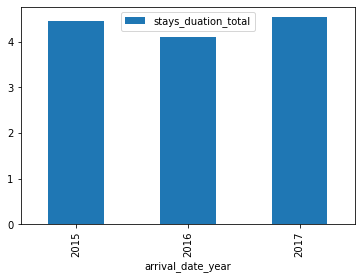

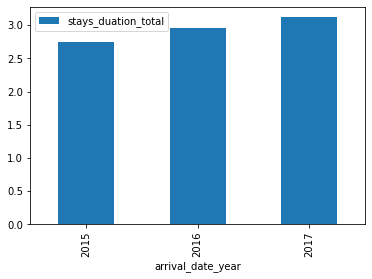

In [101]:
df1["stays_duation_total"] =  df1.stays_in_weekend_nights + df1.stays_in_week_nights
for name in ['Resort Hotel', 'City Hotel']:
    df2 = df1[df1.hotel == name].groupby(['arrival_date_year'])["stays_duation_total"].mean().to_frame()
    df2.plot.bar()
    plt.show()


# **Q3 Answer** <br> 
The average occupation days of resort hotel from 2015 - 2017 are larger then 4 days and that for city hotel is about 2-3 days.<br> 假日酒店的平均预订时间在2015-2017之间在4天左右，而城市酒店平均预订时间相对较少，在2-3天之间。

# **PART 2** <br>Machine Learning: Prediction<br>机器学习：预测客户的退订行为

# **Q1**<br> **Which features are important?<br>**哪一些特征比较重要？

In [102]:
cancel_corr = df.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending = False)

is_canceled                       1.000000
lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

# **Q1 Answer**<br> 
For all numerical features, we compute the correlation of them. The top 5(except for is_canceled) features are important.<br> 我们得出相关系数矩阵并将其排序，发现排在前五个(is_canceled 除外)的数值型特征与is_canceled具有较强相关性。<br> 
    lead_time
    total_of_special_requests
    required_car_parking_spaces
    booking_changes
    previous_cancellations.

# **Q2** <br>**Predict cancel using logistic regression**<br> 使用Logistic 回归预测退订情况

In [103]:
# preprocessing
df = df[df['is_canceled'].notna()]
features = ['lead_time', 'total_of_special_requests', 'required_car_parking_spaces', 'booking_changes','previous_cancellations']
X = df[features]
Y = df["is_canceled"]
# missing value with median
num_transformer = SimpleImputer(strategy="median")
num_transformer.fit_transform(X)
# extract training data (60%) and test data (40%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.40, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression()

Genterate confusion matrix to assess the performance of regression model** <br> 生成混淆矩阵，考察模型的效果

Accuracy: 0.7166010553647709
Precision: 0.6940141167843066
Recall: 0.4261270895480385


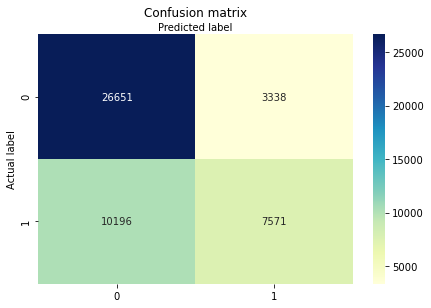

In [104]:
Y_pred=logreg.predict(X_test)
# get confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
# visualize confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# accuracy, percision, recall
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print("Recall:",metrics.recall_score(Y_test, Y_pred))

The performance of logistic regression is not satisfying because the accuray is low: 10196 clients who canceled the reservation are misclassified as normal clients. For this model, we only take numerical features into consideration but ignore categorical one, it's necessary for us to choose another model and make some improvements** <br> 用logistic回归训练出的效果不好，有大量的退订用户被划分为正常用户，因为在这个模型中，我们只考虑了数值类特征但是没有考虑分类型特征，所以我们需要建立另一个模型并做一些改进。

# **Q3**<br>**Using random forest to make predictions**<br>使用随机森林进行预测

The characteristic of random forest is that we do not need to select features maunally, random forest generate several decision tree and combine the classification result of each tree to obtain the final result.**<br>采用随机森林作为新的分类器，随机森林的优点在于我们不用手动选择特征。

# **PART 1 Data preprocessing**<br>数据预处理

In [105]:
# First, we can extract some features from the original features to make model more general:
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, days_in_waiting_list)
# The data can be simply divided into numerial data and categorical data:
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]
cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]
features = num_features + cat_features
X = df.drop(["is_canceled"], axis=1)[features]
y = df["is_canceled"]
# deal with num_features - fill missing value - choose 0 as the filled value for all columns except date
# however, date does not have missing value
# (PS: simpleInputer can be not only used in filling numerical data but also string type data)
num_transformer = SimpleImputer(strategy="constant", fill_value=0)
# deal with categorical data
cat_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy="constant", fill_value="unkown")), 
                                   ("onehot", OneHotEncoder(handle_unknown="ignore"))])
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

# referred from https://www.kaggle.com/marcuswingen/eda-of-bookings-and-ml-to-predict-cancelations

# **PART 2 Model Training**<br>训练模型

In [106]:
# split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
model = Pipeline(steps=[('preprocessor', preprocessor),('rf', RandomForestClassifier(random_state=42,n_jobs=-1))])
model.fit(X_train, y_train)
pred = model.predict(X_test)
#score = metrics.accuracy_score(y_test, pred)
#print("the accuracy score is: ", round(score, 2))


Accuracy: 0.8612739760448949
Precision: 0.8547966134063276
Recall: 0.7555705604321404


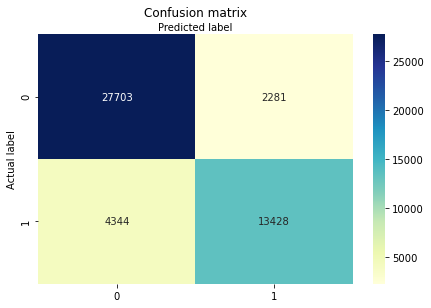

In [107]:
# get confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, pred)
# visualize confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# accuracy, percision, recall
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))

# **Hooray!!!!! The accuracy increase from 0.71 to 0.86, the random forest model is much better than logistic regression one.**<br>模型的精确度从0.71增加到0.86，表现有明显的提升，可见针对这个数据，随机森林模型比logistic 回归更加适用